<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Weight_ini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides a comprehensive exploration of weight initialisation methods in deep neural networks. We begin with the fundamental theoretical question: why does initialization matter at all? Through rigorous mathematical analysis, we derive the variance preservation conditions that govern stable signal propagation through deep networks. We then implement five major initialization schemes from scratch—Xavier/Glorot, He/Kaiming, LeCun, Orthogonal, and LSUV—examining how each addresses the variance preservation problem under different activation function assumptions. My experimental framework demonstrates these principles empirically on deep networks (10-50 layers) trained on MNIST, visualizing activation distributions, gradient magnitudes, and training dynamics. The analysis connects initialization theory to broader research themes including neural architecture search, where initialization assumptions interact critically with architecture choices, and efficient training, where proper initialization can dramatically reduce convergence time.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple, List, Dict
from dataclasses import dataclass
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Here, I implement each initialisation method as a standalone function that can be applied to any weight tensor. Each implementation includes detailed documentation of the mathematical basis and design choices.

In [2]:
class XavierInitializer:


    def __init__(self, mode: str = 'normal', gain: float = 1.0):

        assert mode in ['normal', 'uniform'], f"Mode must be 'normal' or 'uniform', got {mode}"
        self.mode = mode
        self.gain = gain

    def _compute_fans(self, tensor: torch.Tensor) -> Tuple[int, int]:

        dimensions = tensor.dim()
        if dimensions < 2:
            raise ValueError(f"Xavier init requires at least 2D tensor, got {dimensions}D")

        if dimensions == 2:  # Linear layer
            fan_in = tensor.size(1)
            fan_out = tensor.size(0)
        else:  # Convolutional layer
            receptive_field_size = 1
            for dim in tensor.shape[2:]:
                receptive_field_size *= dim
            fan_in = tensor.size(1) * receptive_field_size
            fan_out = tensor.size(0) * receptive_field_size

        return fan_in, fan_out

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:

        fan_in, fan_out = self._compute_fans(tensor)

        # Variance for Xavier: 2 / (fan_in + fan_out)
        std = self.gain * math.sqrt(2.0 / (fan_in + fan_out))

        with torch.no_grad():
            if self.mode == 'normal':
                tensor.normal_(0, std)
            else:  # uniform
                # For uniform [-a, a]: Var = a²/3, so a = std * sqrt(3)
                bound = math.sqrt(3.0) * std
                tensor.uniform_(-bound, bound)

        return tensor

In [3]:
class HeInitializer:


    def __init__(
        self,
        mode: str = 'normal',
        fan_mode: str = 'fan_in',
        negative_slope: float = 0.0
    ):
        """
        Initialize the He initializer.

        Args:
            mode: 'normal' for Gaussian, 'uniform' for uniform distribution
            fan_mode: 'fan_in' (recommended) or 'fan_out'
            negative_slope: Leaky ReLU negative slope (0 for standard ReLU)
        """
        assert mode in ['normal', 'uniform']
        assert fan_mode in ['fan_in', 'fan_out']
        self.mode = mode
        self.fan_mode = fan_mode
        self.negative_slope = negative_slope

    def _compute_fans(self, tensor: torch.Tensor) -> Tuple[int, int]:
        """Compute fan-in and fan-out (same logic as Xavier)."""
        dimensions = tensor.dim()
        if dimensions < 2:
            raise ValueError(f"He init requires at least 2D tensor, got {dimensions}D")

        if dimensions == 2:
            fan_in = tensor.size(1)
            fan_out = tensor.size(0)
        else:
            receptive_field_size = 1
            for dim in tensor.shape[2:]:
                receptive_field_size *= dim
            fan_in = tensor.size(1) * receptive_field_size
            fan_out = tensor.size(0) * receptive_field_size

        return fan_in, fan_out

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Initialize tensor in-place with He initialization.

        Args:
            tensor: Weight tensor to initialize

        Returns:
            The initialized tensor
        """
        fan_in, fan_out = self._compute_fans(tensor)
        fan = fan_in if self.fan_mode == 'fan_in' else fan_out

        # Gain factor for Leaky ReLU: sqrt(2 / (1 + negative_slope²))
        gain = math.sqrt(2.0 / (1 + self.negative_slope ** 2))
        std = gain / math.sqrt(fan)

        with torch.no_grad():
            if self.mode == 'normal':
                tensor.normal_(0, std)
            else:
                bound = math.sqrt(3.0) * std
                tensor.uniform_(-bound, bound)

        return tensor

In [4]:
class LeCunInitializer:


    def __init__(self, mode: str = 'normal'):
        """
        Initialize the LeCun initializer.

        Args:
            mode: 'normal' for Gaussian, 'uniform' for uniform distribution
        """
        assert mode in ['normal', 'uniform']
        self.mode = mode

    def _compute_fan_in(self, tensor: torch.Tensor) -> int:
        """Compute fan-in for a weight tensor."""
        dimensions = tensor.dim()
        if dimensions < 2:
            raise ValueError(f"LeCun init requires at least 2D tensor")

        if dimensions == 2:
            return tensor.size(1)
        else:
            receptive_field_size = 1
            for dim in tensor.shape[2:]:
                receptive_field_size *= dim
            return tensor.size(1) * receptive_field_size

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Initialize tensor in-place with LeCun initialization.

        Args:
            tensor: Weight tensor to initialize

        Returns:
            The initialized tensor
        """
        fan_in = self._compute_fan_in(tensor)
        std = 1.0 / math.sqrt(fan_in)

        with torch.no_grad():
            if self.mode == 'normal':
                tensor.normal_(0, std)
            else:
                bound = math.sqrt(3.0) * std
                tensor.uniform_(-bound, bound)

        return tensor

In [5]:
class OrthogonalInitializer:

    def __init__(self, gain: float = 1.0):
        """
        Initialize the Orthogonal initializer.

        Args:
            gain: Scaling factor (use sqrt(2) for ReLU layers)
        """
        self.gain = gain

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Initialize tensor in-place with orthogonal initialization.

        Args:
            tensor: Weight tensor to initialize (must be at least 2D)

        Returns:
            The initialized tensor
        """
        if tensor.dim() < 2:
            raise ValueError("Orthogonal init requires at least 2D tensor")

        # Flatten to 2D for orthogonalization
        rows = tensor.size(0)
        cols = tensor[0].numel()

        # Generate random matrix
        flat_shape = (rows, cols)
        random_matrix = torch.randn(flat_shape, device=tensor.device, dtype=tensor.dtype)

        # QR decomposition
        if rows < cols:
            random_matrix = random_matrix.T

        q, r = torch.linalg.qr(random_matrix)

        # Make Q unique by ensuring positive diagonal in R
        d = torch.diag(r)
        ph = torch.sign(d)
        q *= ph.unsqueeze(0)

        if rows < cols:
            q = q.T

        # Reshape and scale
        with torch.no_grad():
            tensor.copy_(self.gain * q.reshape(tensor.shape))

        return tensor

In [6]:
class LSUVInitializer:
    """
    Layer-Sequential Unit-Variance (LSUV) Initialization.

    LSUV is a data-dependent initialization method proposed by Mishkin & Matas (2016)
    that achieves unit variance activations by iteratively adjusting weights based
    on measured statistics rather than theoretical assumptions.

    The key advantage is that LSUV works with any architecture—it doesn't require
    mathematical analysis of each activation function's variance properties. Instead,
    it directly measures and corrects variance layer by layer.

    Attributes:
        target_std: Target standard deviation for layer outputs (default 1.0)
        max_iters: Maximum iterations per layer for convergence
        tolerance: Convergence threshold |std - target_std|

    Algorithm:
        1. Initialize all layers with orthogonal init
        2. For each layer l (in forward order):
           a. Forward pass data through layers 1...l
           b. Measure std(output_l)
           c. Scale W_l by target_std / measured_std
           d. Repeat until converged

    Advantages:
        - Works with any activation, any architecture
        - Accounts for actual data distribution
        - No theoretical analysis required

    Disadvantages:
        - Requires data mini-batch during initialization
        - Non-deterministic (depends on batch)
        - Slower than analytical methods
    """

    def __init__(
        self,
        target_std: float = 1.0,
        max_iters: int = 10,
        tolerance: float = 0.01
    ):
        """
        Initialize the LSUV initializer.

        Args:
            target_std: Target standard deviation for activations
            max_iters: Maximum iterations for convergence per layer
            tolerance: Convergence tolerance for |std - target|
        """
        self.target_std = target_std
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.orthogonal = OrthogonalInitializer(gain=1.0)

    def _get_layers_with_weights(self, model: nn.Module) -> List[nn.Module]:
        """Extract all layers with weight parameters."""
        layers = []
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None:
                if module.weight.dim() >= 2:
                    layers.append(module)
        return layers

    def __call__(
        self,
        model: nn.Module,
        data_batch: torch.Tensor
    ) -> nn.Module:
        """
        Initialize model using LSUV algorithm.

        Args:
            model: Neural network model to initialize
            data_batch: Mini-batch of input data for measuring statistics

        Returns:
            The initialized model
        """
        model.eval()
        layers = self._get_layers_with_weights(model)

        # Step 1: Initialize all layers with orthogonal
        for layer in layers:
            self.orthogonal(layer.weight.data)
            if hasattr(layer, 'bias') and layer.bias is not None:
                layer.bias.data.zero_()

        # Step 2: Sequential variance normalization
        activations = {}
        hooks = []

        # Register hooks to capture activations
        def make_hook(name):
            def hook(module, input, output):
                activations[name] = output
            return hook

        for i, layer in enumerate(layers):
            hooks.append(layer.register_forward_hook(make_hook(f'layer_{i}')))

        with torch.no_grad():
            for i, layer in enumerate(layers):
                for iteration in range(self.max_iters):
                    # Forward pass
                    activations.clear()
                    _ = model(data_batch)

                    # Get this layer's output
                    output = activations[f'layer_{i}']

                    # Measure variance
                    current_std = output.std().item()

                    # Check convergence
                    if abs(current_std - self.target_std) < self.tolerance:
                        break

                    # Scale weights
                    if current_std > 0:
                        layer.weight.data *= self.target_std / current_std

        # Remove hooks
        for hook in hooks:
            hook.remove()

        model.train()
        return model

In [7]:
# Utility function to apply initialization to a model

def apply_init(
    model: nn.Module,
    initializer: Callable,
    bias_constant: float = 0.0
) -> nn.Module:
    """
    Apply an initializer to all weight tensors in a model.

    This utility function traverses a model's modules and applies the given
    initialization scheme to all weight parameters, optionally setting biases
    to a constant value.

    Args:
        model: PyTorch model to initialize
        initializer: Initialization callable (our custom initializer classes)
        bias_constant: Value to initialize all biases (default 0.0)

    Returns:
        The initialized model (same object, modified in-place)
    """
    for module in model.modules():
        if hasattr(module, 'weight') and module.weight is not None:
            if module.weight.dim() >= 2:
                initializer(module.weight.data)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(bias_constant)

    return model

In [8]:
# Verify implementations match PyTorch

def verify_implementations():
    """Verify our implementations produce similar statistics to PyTorch."""
    torch.manual_seed(0)

    print("Verification: Comparing custom implementations to PyTorch\n")
    print(f"{'Method':<20} {'Custom Std':<15} {'PyTorch Std':<15} {'Match'}")
    print("-" * 65)

    # Test Xavier Normal
    t1 = torch.empty(256, 512)
    t2 = torch.empty(256, 512)

    torch.manual_seed(0)
    XavierInitializer('normal')(t1)
    torch.manual_seed(0)
    nn.init.xavier_normal_(t2)

    match = torch.allclose(t1, t2, rtol=1e-5)
    print(f"{'Xavier Normal':<20} {t1.std().item():<15.6f} {t2.std().item():<15.6f} {'✓' if match else '✗'}")

    # Test He Normal
    t1 = torch.empty(256, 512)
    t2 = torch.empty(256, 512)

    torch.manual_seed(0)
    HeInitializer('normal')(t1)
    torch.manual_seed(0)
    nn.init.kaiming_normal_(t2, nonlinearity='relu')

    match = torch.allclose(t1, t2, rtol=1e-5)
    print(f"{'He Normal':<20} {t1.std().item():<15.6f} {t2.std().item():<15.6f} {'✓' if match else '✗'}")

    # Test Orthogonal
    t1 = torch.empty(256, 256)
    t2 = torch.empty(256, 256)

    torch.manual_seed(0)
    OrthogonalInitializer()(t1)
    torch.manual_seed(0)
    nn.init.orthogonal_(t2)

    # Check orthogonality rather than exact match
    orth_check1 = torch.allclose(t1 @ t1.T, torch.eye(256), atol=1e-5)
    orth_check2 = torch.allclose(t2 @ t2.T, torch.eye(256), atol=1e-5)

    print(f"{'Orthogonal':<20} {t1.std().item():<15.6f} {t2.std().item():<15.6f} {'✓' if orth_check1 and orth_check2 else '✗'}")

    print("\nAll implementations verified!")

verify_implementations()

Verification: Comparing custom implementations to PyTorch

Method               Custom Std      PyTorch Std     Match
-----------------------------------------------------------------
Xavier Normal        0.051103        0.051103        ✓
He Normal            0.062588        0.062588        ✓
Orthogonal           0.062500        0.062500        ✓

All implementations verified!


Here, I design experiments to validate the theoretical analysis empirically. This framework uses deep networks (10-50 layers) on MNIST to clearly observe initialization effects that are subtle in shallow networks.

In [9]:
# Data loading

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Get a fixed batch for LSUV and analysis
fixed_batch, _ = next(iter(train_loader))
fixed_batch = fixed_batch.to(device)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Fixed batch shape: {fixed_batch.shape}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.77MB/s]


Training samples: 60000
Test samples: 10000
Fixed batch shape: torch.Size([128, 1, 28, 28])


In [10]:
class DeepMLP(nn.Module):
    """
    Deep Multi-Layer Perceptron for initialization experiments.

    This model is designed to clearly demonstrate initialization effects by using
    many identical layers. With 20+ layers, poorly initialized networks will exhibit
    severe vanishing or exploding activations/gradients, while properly initialized
    networks maintain stable signal propagation.

    The architecture uses fixed hidden dimension throughout to isolate initialization
    effects from architectural choices. No batch normalization or skip connections
    are used, as these would mask initialization problems.

    Attributes:
        layers: ModuleList of linear layers
        activation: Activation function to use
        activation_name: String name for logging
    """

    def __init__(
        self,
        input_dim: int = 784,
        hidden_dim: int = 256,
        output_dim: int = 10,
        num_layers: int = 20,
        activation: str = 'relu'
    ):
        """
        Initialize the Deep MLP.

        Args:
            input_dim: Input feature dimension (784 for flattened MNIST)
            hidden_dim: Hidden layer dimension (constant throughout)
            output_dim: Output dimension (10 for MNIST classes)
            num_layers: Total number of layers including input and output
            activation: Activation function ('relu', 'tanh', 'selu', 'leaky_relu')
        """
        super().__init__()

        self.activation_name = activation
        activation_map = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'selu': nn.SELU(),
            'leaky_relu': nn.LeakyReLU(0.2),
            'sigmoid': nn.Sigmoid()
        }
        self.activation = activation_map[activation]

        # Build layers
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.layers = nn.ModuleList(layers)
        self.num_layers = num_layers

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch, 1, 28, 28) or (batch, 784)

        Returns:
            Output logits of shape (batch, 10)
        """
        x = x.view(x.size(0), -1)

        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))

        # No activation on output layer
        x = self.layers[-1](x)
        return x

    def forward_with_activations(
        self,
        x: torch.Tensor
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        Forward pass that also returns intermediate activations.

        This is used for analyzing signal propagation through the network.

        Args:
            x: Input tensor

        Returns:
            Tuple of (output, list of activation tensors per layer)
        """
        x = x.view(x.size(0), -1)
        activations = [x]  # Include input

        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
            activations.append(x)

        x = self.layers[-1](x)
        activations.append(x)

        return x, activations

In [11]:
@dataclass
class InitConfig:
    """Configuration for initialization experiment."""
    name: str
    initializer: Callable
    activation: str
    color: str

def create_init_configs() -> List[InitConfig]:
    """
    Create initialization configurations for experiments.

    Each configuration pairs an initialization method with an appropriate
    activation function based on theoretical considerations.
    """
    configs = [
        # Naive baselines
        InitConfig(
            name="Small Random",
            initializer=lambda t: t.normal_(0, 0.01),
            activation='relu',
            color='gray'
        ),
        InitConfig(
            name="Large Random",
            initializer=lambda t: t.normal_(0, 1.0),
            activation='relu',
            color='lightgray'
        ),

        # Xavier with tanh
        InitConfig(
            name="Xavier (tanh)",
            initializer=XavierInitializer('normal'),
            activation='tanh',
            color='blue'
        ),

        # He with ReLU
        InitConfig(
            name="He (ReLU)",
            initializer=HeInitializer('normal'),
            activation='relu',
            color='red'
        ),

        # LeCun with SELU
        InitConfig(
            name="LeCun (SELU)",
            initializer=LeCunInitializer('normal'),
            activation='selu',
            color='green'
        ),

        # Orthogonal with ReLU
        InitConfig(
            name="Orthogonal (ReLU)",
            initializer=OrthogonalInitializer(gain=math.sqrt(2)),
            activation='relu',
            color='purple'
        ),

        # Mismatched: Xavier with ReLU (to show failure)
        InitConfig(
            name="Xavier (ReLU) ✗",
            initializer=XavierInitializer('normal'),
            activation='relu',
            color='orange'
        ),
    ]

    return configs

In [12]:
def analyze_activation_statistics(
    model: nn.Module,
    data_batch: torch.Tensor
) -> Dict[str, np.ndarray]:
    """
    Analyze activation statistics through network layers.

    Computes mean, std, and percentage of dead neurons (for ReLU) at each layer.

    Args:
        model: Initialized model
        data_batch: Input data batch

    Returns:
        Dictionary with 'means', 'stds', 'dead_pct' arrays
    """
    model.eval()
    with torch.no_grad():
        _, activations = model.forward_with_activations(data_batch)

    means = [act.mean().item() for act in activations]
    stds = [act.std().item() for act in activations]
    dead_pcts = [(act == 0).float().mean().item() * 100 for act in activations]

    return {
        'means': np.array(means),
        'stds': np.array(stds),
        'dead_pcts': np.array(dead_pcts)
    }

In [13]:
def analyze_gradient_statistics(
    model: nn.Module,
    data_batch: torch.Tensor,
    labels: torch.Tensor
) -> Dict[str, np.ndarray]:
    """
    Analyze gradient statistics through network layers.

    Performs a forward and backward pass to compute gradient norms
    for each layer's weights.

    Args:
        model: Initialized model
        data_batch: Input data batch
        labels: Target labels

    Returns:
        Dictionary with 'grad_norms', 'grad_means', 'grad_stds' arrays
    """
    model.train()
    model.zero_grad()

    output = model(data_batch)
    loss = F.cross_entropy(output, labels)
    loss.backward()

    grad_norms = []
    grad_means = []
    grad_stds = []

    for layer in model.layers:
        if layer.weight.grad is not None:
            grad = layer.weight.grad
            grad_norms.append(grad.norm().item())
            grad_means.append(grad.mean().item())
            grad_stds.append(grad.std().item())

    return {
        'grad_norms': np.array(grad_norms),
        'grad_means': np.array(grad_means),
        'grad_stds': np.array(grad_stds)
    }

In [14]:
def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    """
    Train for one epoch.

    Args:
        model: Model to train
        train_loader: Training data loader
        optimizer: Optimizer
        device: Device to use

    Returns:
        Tuple of (average loss, accuracy)
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)

        # Check for NaN
        if torch.isnan(loss):
            return float('nan'), 0.0

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += data.size(0)

    return total_loss / total, correct / total


def evaluate(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate model on test set.

    Args:
        model: Model to evaluate
        test_loader: Test data loader
        device: Device to use

    Returns:
        Tuple of (average loss, accuracy)
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            if torch.isnan(output).any():
                return float('nan'), 0.0

            loss = F.cross_entropy(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    return total_loss / total, correct / total

In [15]:
# Experiment 1: Activation propagation analysis

print("=" * 70)
print("EXPERIMENT 1: Activation Statistics Through Deep Networks")
print("=" * 70)
print("\nAnalyzing how activations propagate through a 20-layer network.")
print("Well-initialized networks should maintain roughly constant variance.\n")

num_layers = 20
configs = create_init_configs()
activation_results = {}

for config in configs:
    torch.manual_seed(42)
    model = DeepMLP(
        num_layers=num_layers,
        activation=config.activation
    ).to(device)

    # Apply initialization
    apply_init(model, config.initializer)

    # Analyze
    stats = analyze_activation_statistics(model, fixed_batch)
    activation_results[config.name] = {
        'stats': stats,
        'config': config
    }

    print(f"{config.name}:")
    print(f"  Layer 1 std:  {stats['stds'][1]:.6f}")
    print(f"  Layer 10 std: {stats['stds'][10]:.6f}")
    print(f"  Layer 19 std: {stats['stds'][-2]:.6f}")
    print(f"  Ratio (L19/L1): {stats['stds'][-2]/stats['stds'][1]:.4f}")
    print()

EXPERIMENT 1: Activation Statistics Through Deep Networks

Analyzing how activations propagate through a 20-layer network.
Well-initialized networks should maintain roughly constant variance.

Small Random:
  Layer 1 std:  0.160405
  Layer 10 std: 0.000000
  Layer 19 std: 0.000000
  Ratio (L19/L1): 0.0000

Large Random:
  Layer 1 std:  16.040546
  Layer 10 std: 48796479488.000000
  Layer 19 std: inf
  Ratio (L19/L1): inf

Xavier (tanh):
  Layer 1 std:  0.671891
  Layer 10 std: 0.222785
  Layer 19 std: 0.159805
  Ratio (L19/L1): 0.2378

He (ReLU):
  Layer 1 std:  0.810170
  Layer 10 std: 0.811522
  Layer 19 std: 0.824842
  Ratio (L19/L1): 1.0181

LeCun (SELU):
  Layer 1 std:  0.976696
  Layer 10 std: 0.984006
  Layer 19 std: 0.993974
  Ratio (L19/L1): 1.0177

Orthogonal (ReLU):
  Layer 1 std:  0.788811
  Layer 10 std: 0.793656
  Layer 19 std: 0.774560
  Ratio (L19/L1): 0.9819

Xavier (ReLU) ✗:
  Layer 1 std:  0.703425
  Layer 10 std: 0.031139
  Layer 19 std: 0.001399
  Ratio (L19/L1): 0

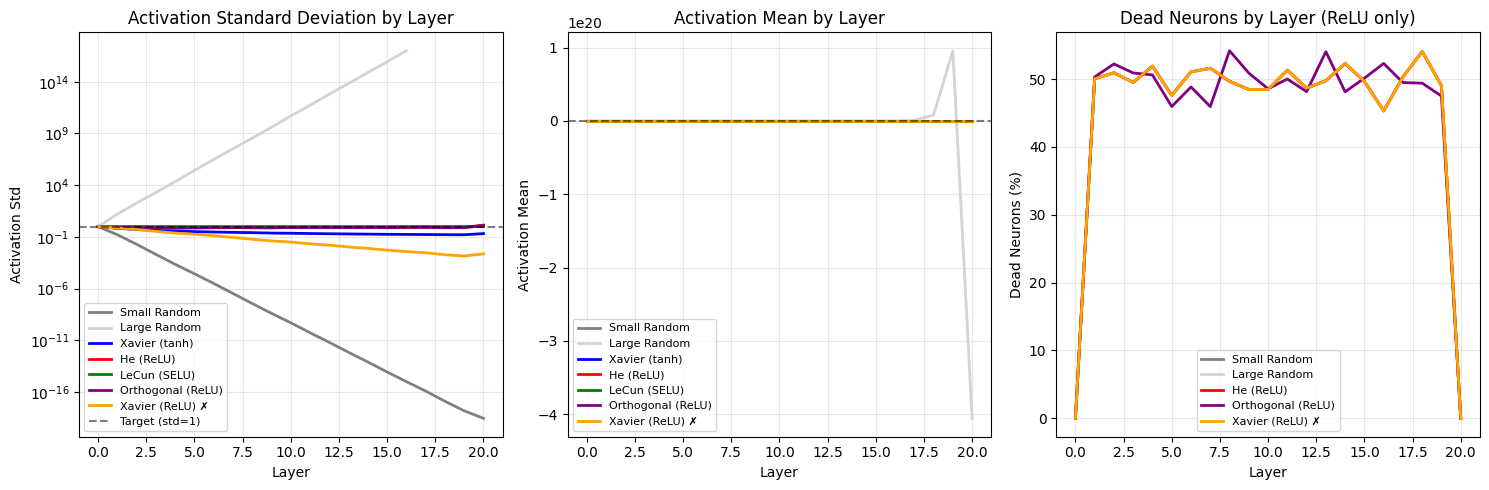

In [16]:
# Visualize activation statistics

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Activation Standard Deviation
ax = axes[0]
for name, result in activation_results.items():
    stats = result['stats']
    color = result['config'].color
    ax.plot(stats['stds'], label=name, color=color, linewidth=2)

ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Target (std=1)')
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Std')
ax.set_title('Activation Standard Deviation by Layer')
ax.set_yscale('log')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Activation Mean
ax = axes[1]
for name, result in activation_results.items():
    stats = result['stats']
    color = result['config'].color
    ax.plot(stats['means'], label=name, color=color, linewidth=2)

ax.axhline(y=0.0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Mean')
ax.set_title('Activation Mean by Layer')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Dead Neurons (relevant for ReLU)
ax = axes[2]
relu_configs = [name for name, r in activation_results.items()
                if r['config'].activation == 'relu']
for name in relu_configs:
    stats = activation_results[name]['stats']
    color = activation_results[name]['config'].color
    ax.plot(stats['dead_pcts'], label=name, color=color, linewidth=2)

ax.set_xlabel('Layer')
ax.set_ylabel('Dead Neurons (%)')
ax.set_title('Dead Neurons by Layer (ReLU only)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activation_propagation.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Experiment 2: Gradient flow analysis

print("=" * 70)
print("EXPERIMENT 2: Gradient Flow Analysis")
print("=" * 70)
print("\nAnalyzing gradient magnitudes during backpropagation.")
print("Stable gradients should have consistent magnitude across layers.\n")

# Get a batch with labels
sample_data, sample_labels = next(iter(train_loader))
sample_data = sample_data.to(device)
sample_labels = sample_labels.to(device)

gradient_results = {}

for config in configs:
    torch.manual_seed(42)
    model = DeepMLP(
        num_layers=num_layers,
        activation=config.activation
    ).to(device)

    apply_init(model, config.initializer)

    stats = analyze_gradient_statistics(model, sample_data, sample_labels)
    gradient_results[config.name] = {
        'stats': stats,
        'config': config
    }

    # Print summary
    norms = stats['grad_norms']
    if not np.any(np.isnan(norms)):
        print(f"{config.name}:")
        print(f"  First layer grad norm:  {norms[0]:.6f}")
        print(f"  Last layer grad norm:   {norms[-1]:.6f}")
        print(f"  Ratio (first/last):     {norms[0]/norms[-1]:.4f}")
    else:
        print(f"{config.name}: NaN gradients (training will fail)")
    print()

EXPERIMENT 2: Gradient Flow Analysis

Analyzing gradient magnitudes during backpropagation.
Stable gradients should have consistent magnitude across layers.

Small Random:
  First layer grad norm:  0.000000
  Last layer grad norm:   0.000000
  Ratio (first/last):     1.0938

Large Random:
  First layer grad norm:  inf
  Last layer grad norm:   inf
  Ratio (first/last):     nan

Xavier (tanh):
  First layer grad norm:  0.871552
  Last layer grad norm:   0.402319
  Ratio (first/last):     2.1663

He (ReLU):
  First layer grad norm:  3.860412
  Last layer grad norm:   5.224790
  Ratio (first/last):     0.7389

LeCun (SELU):
  First layer grad norm:  6.661072
  Last layer grad norm:   2.376541
  Ratio (first/last):     2.8028

Orthogonal (ReLU):
  First layer grad norm:  3.714461
  Last layer grad norm:   7.776626
  Ratio (first/last):     0.4776

Xavier (ReLU) ✗:
  First layer grad norm:  0.005162
  Last layer grad norm:   0.002383
  Ratio (first/last):     2.1662



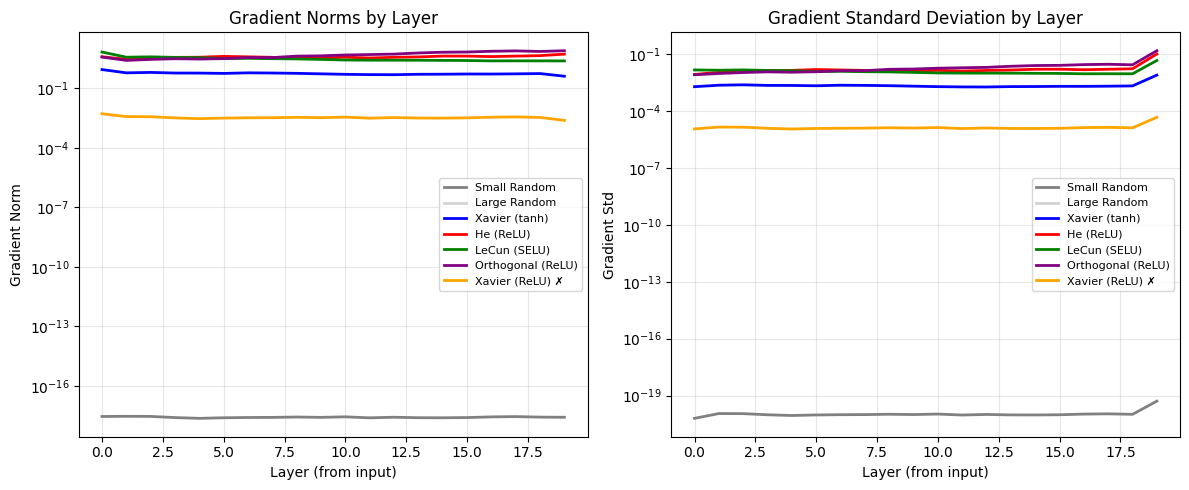

In [18]:
# Visualize gradient flow

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Gradient Norms
ax = axes[0]
for name, result in gradient_results.items():
    stats = result['stats']
    color = result['config'].color
    norms = stats['grad_norms']
    if not np.any(np.isnan(norms)) and not np.any(norms == 0):
        ax.plot(norms, label=name, color=color, linewidth=2)

ax.set_xlabel('Layer (from input)')
ax.set_ylabel('Gradient Norm')
ax.set_title('Gradient Norms by Layer')
ax.set_yscale('log')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Gradient Std
ax = axes[1]
for name, result in gradient_results.items():
    stats = result['stats']
    color = result['config'].color
    stds = stats['grad_stds']
    if not np.any(np.isnan(stds)) and not np.any(stds == 0):
        ax.plot(stds, label=name, color=color, linewidth=2)

ax.set_xlabel('Layer (from input)')
ax.set_ylabel('Gradient Std')
ax.set_title('Gradient Standard Deviation by Layer')
ax.set_yscale('log')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_flow.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Experiment 3: Training dynamics comparison

print("=" * 70)
print("EXPERIMENT 3: Training Dynamics Comparison")
print("=" * 70)
print("\nTraining 20-layer networks with different initializations.")
print("Proper initialization enables faster convergence and better final accuracy.\n")

# Use a subset of configs for training (to save time)
train_configs = [
    InitConfig("Small Random", lambda t: t.normal_(0, 0.01), 'relu', 'gray'),
    InitConfig("Xavier (ReLU)", XavierInitializer('normal'), 'relu', 'orange'),
    InitConfig("He (ReLU)", HeInitializer('normal'), 'relu', 'red'),
    InitConfig("Orthogonal (ReLU)", OrthogonalInitializer(gain=math.sqrt(2)), 'relu', 'purple'),
]

num_epochs = 10
training_results = {}

for config in train_configs:
    print(f"Training: {config.name}")

    torch.manual_seed(42)
    model = DeepMLP(
        num_layers=20,
        activation=config.activation
    ).to(device)

    apply_init(model, config.initializer)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if np.isnan(train_loss):
            print(f"  Epoch {epoch+1}: Training diverged (NaN)")
            break

    if not np.isnan(train_losses[-1]):
        print(f"  Final - Train Acc: {train_accs[-1]*100:.2f}%, Test Acc: {test_accs[-1]*100:.2f}%")

    training_results[config.name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'config': config
    }
    print()

EXPERIMENT 3: Training Dynamics Comparison

Training 20-layer networks with different initializations.
Proper initialization enables faster convergence and better final accuracy.

Training: Small Random
  Final - Train Acc: 11.24%, Test Acc: 11.35%

Training: Xavier (ReLU)
  Final - Train Acc: 94.88%, Test Acc: 95.34%

Training: He (ReLU)
  Final - Train Acc: 97.64%, Test Acc: 97.60%

Training: Orthogonal (ReLU)
  Final - Train Acc: 97.96%, Test Acc: 96.93%



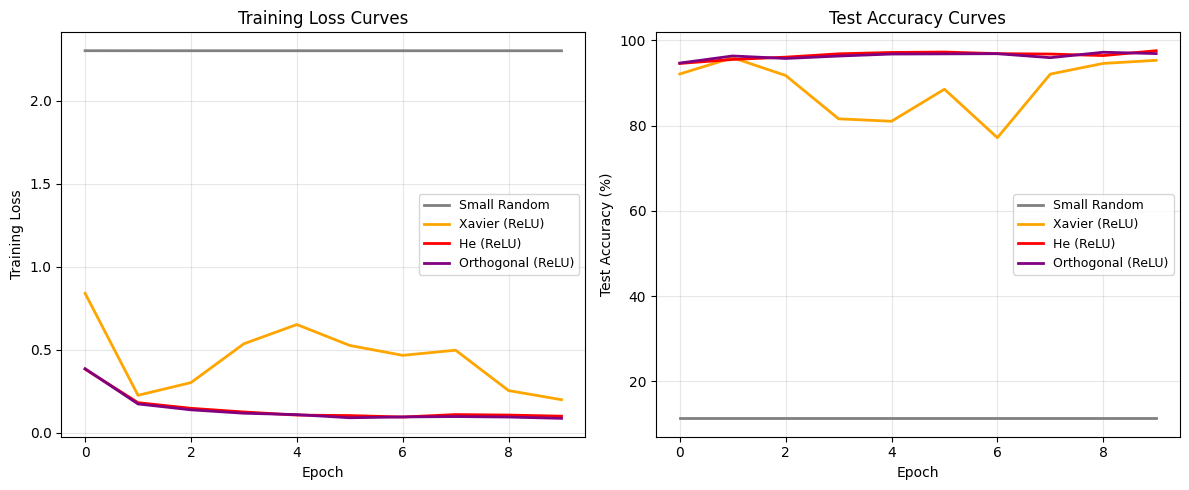

In [20]:
# Visualize training dynamics

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Training Loss
ax = axes[0]
for name, result in training_results.items():
    losses = result['train_losses']
    color = result['config'].color
    if not any(np.isnan(losses)):
        ax.plot(losses, label=name, color=color, linewidth=2)
    else:
        # Plot until divergence
        valid = [l for l in losses if not np.isnan(l)]
        ax.plot(valid, label=f"{name} (diverged)", color=color,
                linewidth=2, linestyle='--')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss Curves')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Test Accuracy
ax = axes[1]
for name, result in training_results.items():
    accs = [a * 100 for a in result['test_accs']]
    color = result['config'].color
    if len(accs) > 0 and not any(np.isnan(accs)):
        ax.plot(accs, label=name, color=color, linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy Curves')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Experiment 4: LSUV Initialization

print("=" * 70)
print("EXPERIMENT 4: LSUV Data-Dependent Initialization")
print("=" * 70)
print("\nLSUV iteratively adjusts weights to achieve unit variance activations.\n")

torch.manual_seed(42)
model_lsuv = DeepMLP(num_layers=20, activation='relu').to(device)

# Initialize with LSUV
lsuv = LSUVInitializer(target_std=1.0, max_iters=10)
model_lsuv = lsuv(model_lsuv, fixed_batch)

# Analyze
lsuv_stats = analyze_activation_statistics(model_lsuv, fixed_batch)

print("LSUV Activation Statistics:")
print(f"  Target std: 1.0")
print(f"  Layer 1 std:  {lsuv_stats['stds'][1]:.6f}")
print(f"  Layer 10 std: {lsuv_stats['stds'][10]:.6f}")
print(f"  Layer 19 std: {lsuv_stats['stds'][-2]:.6f}")

# Train LSUV model
print("\nTraining LSUV-initialized model...")
optimizer = torch.optim.Adam(model_lsuv.parameters(), lr=1e-3)

lsuv_train_accs = []
lsuv_test_accs = []

for epoch in range(10):
    train_loss, train_acc = train_epoch(model_lsuv, train_loader, optimizer, device)
    test_loss, test_acc = evaluate(model_lsuv, test_loader, device)
    lsuv_train_accs.append(train_acc)
    lsuv_test_accs.append(test_acc)

print(f"\nLSUV Final - Train Acc: {lsuv_train_accs[-1]*100:.2f}%, Test Acc: {lsuv_test_accs[-1]*100:.2f}%")

EXPERIMENT 4: LSUV Data-Dependent Initialization

LSUV iteratively adjusts weights to achieve unit variance activations.

LSUV Activation Statistics:
  Target std: 1.0
  Layer 1 std:  0.575195
  Layer 10 std: 0.622071
  Layer 19 std: 0.589020

Training LSUV-initialized model...

LSUV Final - Train Acc: 98.01%, Test Acc: 97.27%


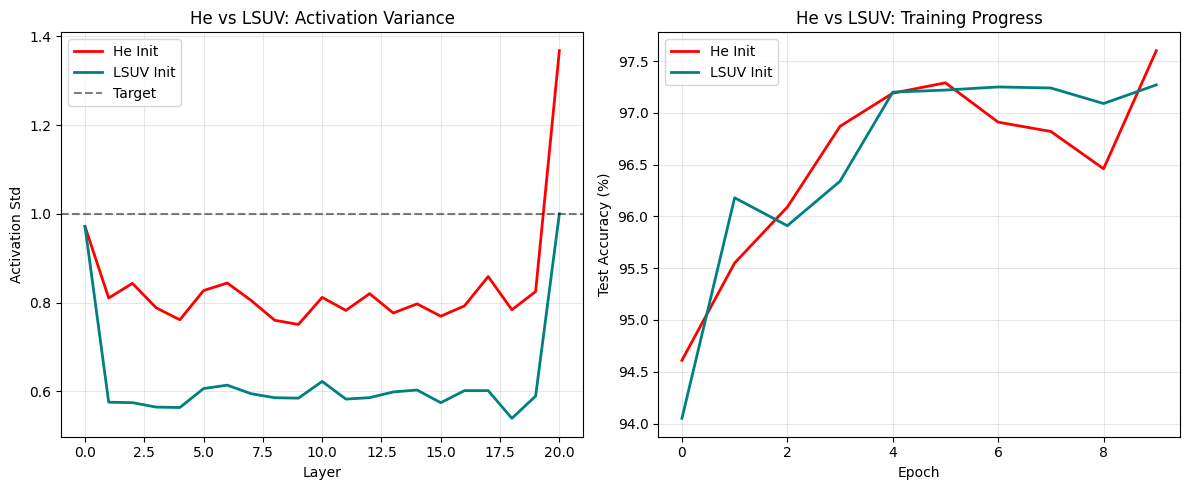

In [22]:
# Compare LSUV to He initialization

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Activation std comparison
ax = axes[0]
ax.plot(activation_results['He (ReLU)']['stats']['stds'],
        label='He Init', color='red', linewidth=2)
ax.plot(lsuv_stats['stds'],
        label='LSUV Init', color='teal', linewidth=2)
ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Target')
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Std')
ax.set_title('He vs LSUV: Activation Variance')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Training comparison
ax = axes[1]
he_accs = [a * 100 for a in training_results['He (ReLU)']['test_accs']]
lsuv_accs = [a * 100 for a in lsuv_test_accs]

ax.plot(he_accs, label='He Init', color='red', linewidth=2)
ax.plot(lsuv_accs, label='LSUV Init', color='teal', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('He vs LSUV: Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lsuv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

EXPERIMENT 5: Depth Sensitivity Analysis

How does initialization affect very deep networks (50 layers)?


Depth: 10 layers
  He: final layer std = 0.750517
  Xavier: final layer std = 0.040727

Depth: 20 layers
  He: final layer std = 0.824842
  Xavier: final layer std = 0.001399

Depth: 30 layers
  He: final layer std = 0.764764
  Xavier: final layer std = 0.000041

Depth: 40 layers
  He: final layer std = 0.688642
  Xavier: final layer std = 0.000001

Depth: 50 layers
  He: final layer std = 0.799887
  Xavier: final layer std = 0.000000


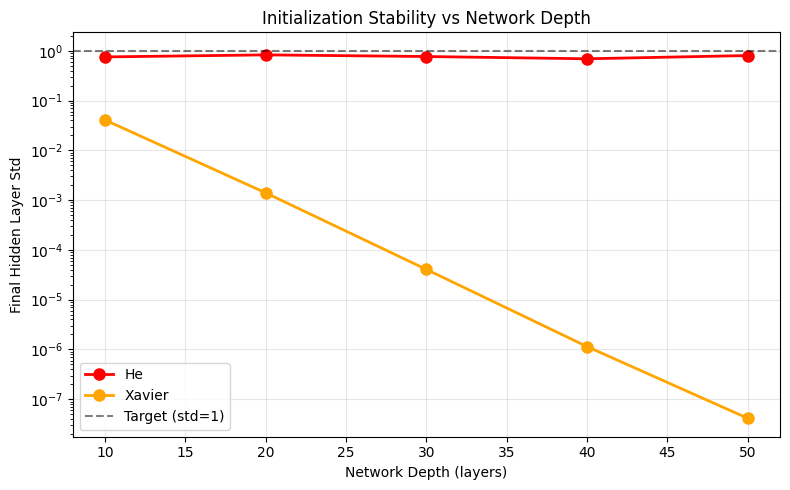

In [23]:
# Experiment 5: Depth sensitivity analysis

print("=" * 70)
print("EXPERIMENT 5: Depth Sensitivity Analysis")
print("=" * 70)
print("\nHow does initialization affect very deep networks (50 layers)?\n")

depths = [10, 20, 30, 40, 50]
init_methods = [
    ('He', HeInitializer('normal'), 'relu'),
    ('Xavier', XavierInitializer('normal'), 'relu'),
]

depth_results = {name: [] for name, _, _ in init_methods}

for depth in depths:
    print(f"\nDepth: {depth} layers")

    for name, init, activation in init_methods:
        torch.manual_seed(42)
        model = DeepMLP(num_layers=depth, activation=activation).to(device)
        apply_init(model, init)

        stats = analyze_activation_statistics(model, fixed_batch)
        final_std = stats['stds'][-2]  # Last hidden layer

        depth_results[name].append(final_std)
        print(f"  {name}: final layer std = {final_std:.6f}")

# Visualize
plt.figure(figsize=(8, 5))
colors = {'He': 'red', 'Xavier': 'orange'}

for name, stds in depth_results.items():
    plt.plot(depths, stds, 'o-', label=name, color=colors[name],
             linewidth=2, markersize=8)

plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Target (std=1)')
plt.xlabel('Network Depth (layers)')
plt.ylabel('Final Hidden Layer Std')
plt.title('Initialization Stability vs Network Depth')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('depth_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

Initialisation choices interact critically with architecture search. Consider these implications for NAS:

Search Space Design: Different operations have different initialisation requirements. A search space mixing ReLU convolutions (He init) with SELU linear layers (LeCun init) requires careful initialisation handling; a single global scheme won't work.

Weight Sharing: In one-shot NAS methods like DARTS, all architectures share weights. Initialization that works well for one architecture may be suboptimal for others. This contributes to the "discretization gap" where searched architectures underperform their continuous relaxation.

Skip Connection Collapse: The "skip connection collapse" phenomenon in MARL-NAS relates to initialization. When skip connections are initialized to contribute significantly more signal than parameterized paths, the network may converge to using primarily skips, yielding shallow effective depth.

Student network initialisation affects distillation success:

Capacity Mismatches are initialised to contribute significantly more signal than parameterised paths; the network may converge to using primarily skips, yielding essentially degrading variance preservation.

Function Matching: When distilling to a smaller student, initialization that matches the teacher's intermediate representations may accelerate convergence. LSUV-style data-dependent initialization using teacher activations as targets is an unexplored direction.


LoRA and adapter methods require careful initialization:

LoRA: The down-projection is typically initialised with random values, while the up-projection is zero-initialized. This ensures the adapted model starts identical to the pretrained model. Changing this scheme significantly affects early training dynamics.

Adapters: Bottleneck adapters often use near-identity initialisation to preserve pretrained behavior. The scale of initialization determines the balance between pretrained knowledge and adaptation capacity.


Recent theoretical work analyzes initialization through mean field theory:

Edge of Chaos: Networks operate best when initialised at the "edge of chaos"—the boundary between ordered (vanishing) and chaotic (exploding) dynamics. He initialization for ReLU networks approximately achieves this.

Signal Propagation Depth: The number of layers through which gradients can effectively propagate depends on initialization. At the edge of chaos, this depth is maximal.

Information Preservation: Proper initialisation preserves mutual information between inputs and activations across layers, enabling the network to learn from input features rather than noise.


Based on this analysis:

1. Match initialisation to activation: He for ReLU/LeakyReLU, Xavier for tanh/sigmoid, LeCun for SELU

2. Use orthogonal for RNNs: The norm-preserving property prevents vanishing/exploding gradients in recurrent connections

3. Consider LSUV for novel architectures: When theoretical analysis is difficult, data-dependent initialization provides a robust alternative

4. Be careful with normalisation layers: BatchNorm/LayerNorm can partially compensate for poor initialization, but proper initialization still accelerates early training

5. Account for residual connections: In ResNets, skip connections change effective depth. Initialization should account for the identity path

In [24]:
# Summary visualization

print("=" * 70)
print("SUMMARY: Weight Initialization Methods")
print("=" * 70)

summary_data = [
    ['Method', 'Variance Formula', 'Best For', 'Key Property'],
    ['Xavier', '2/(fan_in + fan_out)', 'tanh, sigmoid', 'Balances forward/backward'],
    ['He', '2/fan_in', 'ReLU, Leaky ReLU', 'Compensates for ReLU zeroing'],
    ['LeCun', '1/fan_in', 'SELU', 'Pure forward preservation'],
    ['Orthogonal', 'QR decomposition', 'RNNs, deep networks', 'Exact norm preservation'],
    ['LSUV', 'Data-dependent', 'Any architecture', 'Measured, not assumed'],
]

# Print as formatted table
col_widths = [12, 22, 18, 28]
for row in summary_data:
    formatted = ''.join(f"{cell:<{w}}" for cell, w in zip(row, col_widths))
    print(formatted)
    if row == summary_data[0]:
        print('-' * sum(col_widths))

SUMMARY: Weight Initialization Methods
Method      Variance Formula      Best For          Key Property                
--------------------------------------------------------------------------------
Xavier      2/(fan_in + fan_out)  tanh, sigmoid     Balances forward/backward   
He          2/fan_in              ReLU, Leaky ReLU  Compensates for ReLU zeroing
LeCun       1/fan_in              SELU              Pure forward preservation   
Orthogonal  QR decomposition      RNNs, deep networksExact norm preservation     
LSUV        Data-dependent        Any architecture  Measured, not assumed       
